# I$^-$/I$^0$ angle analysis from MD and QM

In [1]:
%reset -f
%load_ext autoreload
%autoreload 2

import matplotlib, glob, sys
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
matplotlib.rc('text', usetex=True)
#matplotlib.rc('text.latex', preamble=r'\usepackage{cmbright}')
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'figure.autolayout': True})


import MDAnalysis as mda
import MDAnalysis.transformations as trans

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore")

import nglview as nv

sys.path.append('../OpenMM/omm_astools/')


/home/jupyter-asod/.local/lib/python3.9/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


##### Load MM data

You need to change the next cell to load both your I0 and I- results

In [18]:
types = ['I-', 'I0']  # load both I- an I0 results

unis = []
for t in types:
    dcd = glob.glob(f'/media/jupyter-asod/prometheus/I-/I0_vKuhl/I0_vKuhl_{t}*.dcd')
    u = mda.Universe('/media/jupyter-asod/prometheus/I-/I0_vKuhl/I0_solv.prmtop', dcd)
    unis.append(u)

Show the I- results, to make sure things are as they are supposed to:

In [6]:
u = unis[0]
v = nv.show_mdanalysis(u)
v.add_representation('licorice')
v

NGLWidget(max_frame=19999)

#### Cut out central molecules

set `mols_to_cutout` to the number of closest waters you want to perform the analysis on. 

The code below will center the I central atom, wrap the waters, and cut out the molecules. 

`rlim` is the max radius the code will look for neighbouring molecules. The smaller it is, the faster the code is, BUT if you choose a radius that has fewer molecules than you asked for, you **will** get strange results!

In [12]:
mols_to_cutout = 6

In [65]:
from cmm.tools.analysis import Sheller
shell = Sheller(u,  # MD-Analysis universe
                name='test', # prefix of final trajectory name
                solutesel='name I')  # selection of the I atom

shell.cut2ase(start=0, # start frame of trajectory
              end=-1,  # end frame of trajectory
              step=25, # sample every nth step of trajectory
              nlim=mols_to_cutout, 
              rlim=20, # read above 
              centersel=shell.solusel)

0it [00:00, ?it/s]

The resulting trajectory will be called `<name_cut_nX-rR.traj>` where `X` is the number you set in `mols_to_cutout` and `R` whatever you used for `rlim`. 

Lets confirm we got what we were after:

In [38]:
from ase.io import Trajectory
traj = Trajectory('test_cut-n6-r25.traj')
nv.show_asetraj(traj)

NGLWidget(max_frame=799)

In [48]:
nv.show_ase(traj[0][:4])

NGLWidget()

Define function to measure angles

In [84]:
atoms = traj[0]

def get_angles(atoms):
    ''' Get all I-OH angles, 2 per I-Water pair. 
        Also (!) save both of the IH distances 
        (could be interesting later) 
        
        Assumes IOHHIOHHIOHH... sequence. As made by the Sheller
    '''
    
    o_idx = list(range(1, len(atoms), 3))
    
    all_angs = np.zeros((len(o_idx), 2))
    all_dsts = np.zeros((len(o_idx), 2))
    
    for i, o in enumerate(o_idx):
        angs = [atoms.get_angle(0, o, o + i) for i in range(1, 3)]
        dsts = atoms.get_distances(0, [o + 1, o + 2])
        
        all_angs[i, :] = angs
        all_dsts[i, :] = dsts
        
    return all_angs, all_dsts

    

Measure angles

In [85]:
angles = np.zeros((mols_to_cutout, len(traj), 2))  # Dim: #waters, trajectory-length, H1H2
ihdist = np.zeros((mols_to_cutout, len(traj), 2))

for a, atoms in enumerate(traj):
    angles[:, a, :], ihdist[:, a, :]  = get_angles(atoms)

Histogram results, dividing up the angle distributions based on the H distances from I:

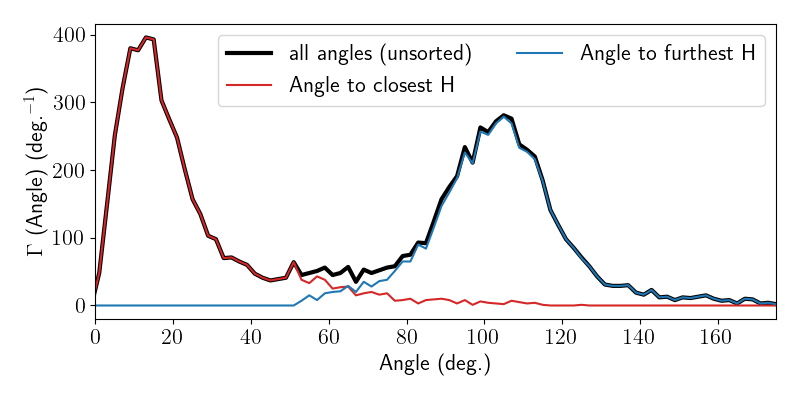

In [86]:
da = 2  # angle bin size
bins = np.arange(-da, 180, da)  # create list of bins
all_hist, _ = np.histogram(angles.ravel(), bins)  # simple histogram of ALL angles

# Select all the angles from the hydrogen _closest_ to I
closest = np.argmin(ihdist, axis=-1)
closest_angles = angles[np.arange(angles.shape[0])[:, np.newaxis], 
                        np.arange(angles.shape[1]), closest]

# Select all the angles from the hydrogen _furthest_ from I
distal = np.argmax(ihdist, axis=-1)
distal_angles = angles[np.arange(angles.shape[0])[:, np.newaxis], 
                       np.arange(angles.shape[1]), distal]

# Histogram them
close_hist, _ = np.histogram(closest_angles.ravel(), bins)  
distal_hist, _ = np.histogram(distal_angles.ravel(), bins)  

fig, ax = plt.subplots(1, 1, figsize=(8, 4));  
ax.plot(bins[1:] - 0.5 * da, all_hist, 'k', lw=3, label='all angles (unsorted)')
ax.plot(bins[1:] - 0.5 * da, close_hist, 'C3', label='Angle to closest H')
ax.plot(bins[1:] - 0.5 * da, distal_hist, 'C0', label='Angle to furthest H')
ax.set_xlabel('Angle (deg.)')
ax.set_ylabel('$\Gamma$ (Angle) (deg.$^{-1}$)')
ax.set_xlim([0, 175])
ax.legend(loc='best', ncol=2);

So here its pretty clear that for I$^-$, the closest hydrogen has a small angle (i.e. points towards H:
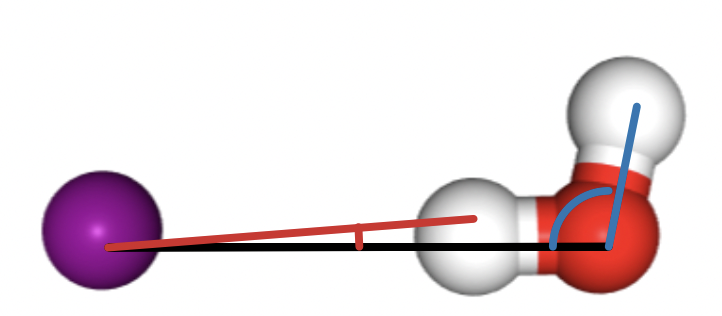

We can also do a simple correlation plot of distances vs angles:

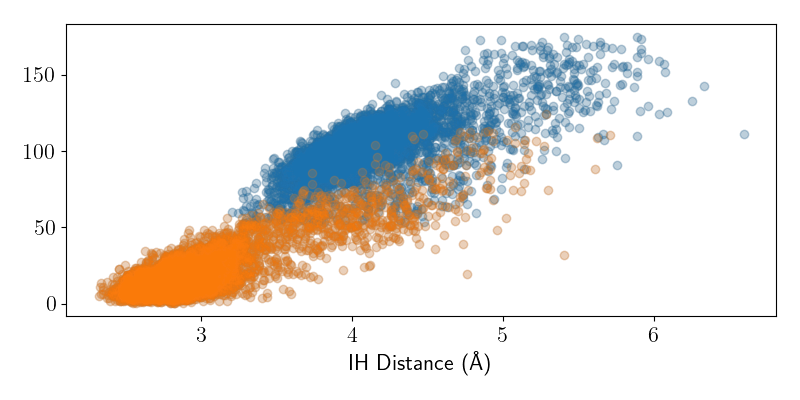

In [87]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4));  
ax.scatter(ihdist.ravel(), angles.ravel(), color='k', alpha=0.1)
ax.scatter(np.max(ihdist, axis=-1).ravel(), distal_angles.ravel(), alpha=0.2)
ax.scatter(np.min(ihdist, axis=-1).ravel(), closest_angles.ravel(), alpha=0.2)
ax.set_xlabel('IH Distance (Å)')
ax.set_label('Angle (deg.)')

There's a clear correlation, the closer the water, the more one of the Hs point toward I$^-$

Lets include I0 also. Select the 2nd universe in the list, and cut out:

In [22]:
u = unis[1]

In [23]:
from cmm.tools.analysis import Sheller
shell = Sheller(u,  # MD-Analysis universe
                name='I0', # prefix of final trajectory name
                solutesel='name I')  # selection of the I atom

shell.cut2ase(start=0, # start frame of trajectory
              end=-1,  # end frame of trajectory
              step=25, # sample every nth step of trajectory
              nlim=mols_to_cutout, 
              rlim=20, # read above 
              centersel=shell.solusel)

0it [00:00, ?it/s]

This time we want to plot both I- and I0 at the same time, so lets turn some of the previous cells into a function, so we can use it quickly multiple times

In [88]:
def get_histograms(traj, da=3):
    angles = np.zeros((mols_to_cutout, len(traj), 2))  # Dim: #waters, trajectory-length, H1H2
    ihdist = np.zeros((mols_to_cutout, len(traj), 2))
    for a, atoms in enumerate(traj):
        angles[:, a, :], ihdist[:, a, :]  = get_angles(atoms)
        
    da = 3  # angle bin size
    bins = np.arange(-da, 180 + da, da)  # create list of bins
    all_hist, _ = np.histogram(angles.ravel(), bins)  # simple histogram of ALL angles

    # Select all the angles from the hydrogen _closest_ to I
    closest = np.argmin(ihdist, axis=-1)
    closest_angles = angles[np.arange(angles.shape[0])[:, np.newaxis], 
                            np.arange(angles.shape[1]), closest]

    # Select all the angles from the hydrogen _furthest_ from I
    distal = np.argmax(ihdist, axis=-1)
    distal_angles = angles[np.arange(angles.shape[0])[:, np.newaxis], 
                           np.arange(angles.shape[1]), distal]

    # Histogram them
    close_hist, _ = np.histogram(closest_angles.ravel(), bins)  
    distal_hist, _ = np.histogram(distal_angles.ravel(), bins)
    
    return bins, all_hist, close_hist, distal_hist


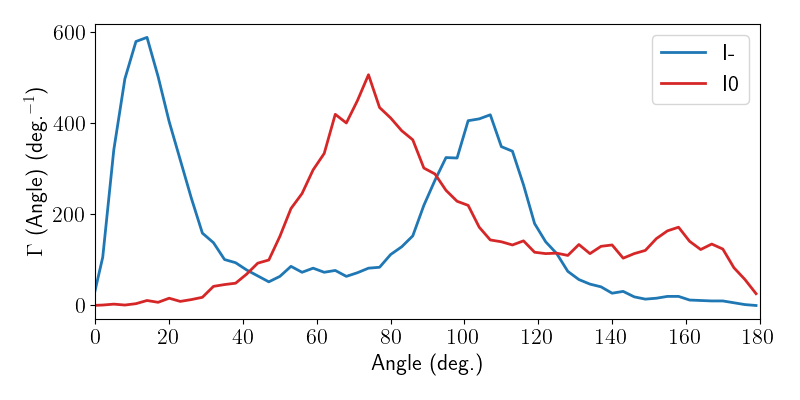

In [89]:
trajnames = ['test_cut-n6-r25.traj', 'I0_cut-n6-r20.traj']
labels = ['I-', 'I0']
fig, ax = plt.subplots(1, 1, figsize=(8, 4));  

for i, tn in enumerate(trajnames):
    traj = Trajectory(tn, 'r')
    bins, all_hist, closest_hist, distal_hist = get_histograms(traj)

    ax.plot(bins[1:] - 0.5 * da, all_hist, ['C0', 'C3'][i], lw=2, label=labels[i])
    #ax.plot(bins[1:] - 0.5 * da, close_hist, label='Angle to closest H')
    #ax.plot(bins[1:] - 0.5 * da, distal_hist, label='Angle to furtest H')


ax.set_xlabel('Angle (deg.)')
ax.set_ylabel('$\Gamma$ (Angle) (deg.$^{-1}$)')
ax.set_xlim([0, 180])
ax.legend(loc='best');

As expected, the I0 population does not have direction. How would a completely random orientation look like? 

Maybe one could do some more clever filtering here to learn more... 

## Next steps:

1. Compare to angles from QM (measure them the same way as here)
2. Redo the whole thing for the closest .. 10 water molecules? 20 ? 26 ? Look what the estimate was for the 2nd shell. 